# Logistic Regression with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

## Build test and training sets & define preprocessing

In [3]:
NUM_WORDS = 50000
MAXLEN = 1000
NGRAM_RANGE = 1

In [4]:
train, test, preproc = text.texts_from_csv('./data/train.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='./data/test.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17751
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1526
	95percentile : 4005
	99percentile : 7619
x_train shape: (647,1000)
y_train shape: (647, 2)
Is Multi-Label? False
162 test sequences
test sequence lengths:
	mean : 1414
	95percentile : 3320
	99percentile : 7203
x_test shape: (162,1000)
y_test shape: (162, 2)


## Define and train the model

We'll need to dig into the ktrain code to determine what exactly they're doing.

In [5]:
model = text.text_classifier('logreg', train, preproc=preproc)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

Is Multi-Label? False
compiling word ID features...
maxlen is 1000
done.


### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

In [6]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


/Users/gregorytozzi/opt/anaconda3/lib/python3.7/site-packages/ktrain/core.py:464: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  warnings.warn('max_epochs is being set to 5 since steps per epoch is small. ' +\


Train on 647 samples
Epoch 1/5
647/647 [==============================] - 0s 700us/sample - loss: 0.8997 - accuracy: 0.4266
Epoch 2/5
647/647 [==============================] - 0s 119us/sample - loss: 0.8385 - accuracy: 0.4250
Epoch 3/5
647/647 [==============================] - 0s 107us/sample - loss: 0.6527 - accuracy: 0.6306
Epoch 4/5
647/647 [==============================] - 0s 110us/sample - loss: 1.2530 - accuracy: 0.7419
Epoch 5/5
 32/647 [>.............................] - ETA: 0s - loss: 3.8352 - accuracy: 0.7500

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


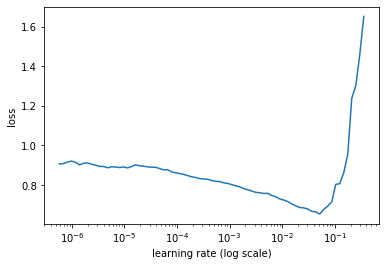

In [7]:
learner.lr_plot()

### Train

In [8]:
learner.autofit(0.1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.1...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 0s 259us/sample - loss: 2.1715 - accuracy: 0.6414 - val_loss: 3.1932 - val_accuracy: 0.6914
Epoch 2/1024
647/647 [==============================] - 0s 145us/sample - loss: 1.4668 - accuracy: 0.8439 - val_loss: 4.4536 - val_accuracy: 0.6358
Epoch 3/1024
480/647 [=====================>........] - ETA: 0s - loss: 0.7317 - accuracy: 0.9042
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.05 (if not early_stopping).
647/647 [==============================] - 0s 144us/sample - loss: 0.8044 - accuracy: 0.9073 - val_loss: 4.2261 - val_accuracy: 0.6605
Epoch 4/1024
647/647 [==============================] - 0s 146us/sample - loss: 0.3206 - accuracy: 0.9567 - val_loss: 3.0176 - val_accuracy: 0.7284
Epoch

## Examine results

In [9]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.65      0.63      0.64        65
           1       0.76      0.77      0.77        97

    accuracy                           0.72       162
   macro avg       0.70      0.70      0.70       162
weighted avg       0.71      0.72      0.72       162



array([[41, 24],
       [22, 75]])

In [10]:
import pandas as pd
X_test = pd.read_csv('./data/test.csv')['cleaned_contents']

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
predictor.explain(X_test[0])